In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import sys
import pdb
import matplotlib.pyplot as plt
from glob import glob
import pickle
from pyuoi.linear_model.var import VAR
from tqdm import tqdm
import pandas as pd
from neurosim.models.var import VAR as VARss
from neurosim.models.var import form_companion
from copy import deepcopy
#from dstableFGM import dstable_descent

In [3]:
import torch
from dca.cov_util import calc_cross_cov_mats_from_data
from dca_research.lqg import build_loss
from sklearn.model_selection import KFold

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sys.path.append('../..')
from loaders import load_sabes
from subspaces import estimate_autocorrelation
from utils import apply_df_filters

In [27]:
# Read in the sbatch file, remove lines associated with to_do 0 entries, and adjust the total nodes requested
with open('/home/akumar/nse/neural_control/sbatch_resume.sh', 'r') as sbatch:
    headers = []
    header_segment = True
    while header_segment:
        ln = sbatch.readline()
        if ln[0:4] == 'srun':
            header_segment = False
        else:
            headers.append(ln)

    srun_statements = [ln for ln in sbatch][0:-1]
    nums = [int(ln.split('.dat')[0].split('arg')[1]) for ln in srun_statements]

### Score (FCCA/Variance) vs. dimension, Indy

In [6]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    sabes_df = pickle.load(f)
sabes_df = pd.DataFrame(sabes_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
data_files = np.unique(sabes_df['data_file'].values)
folds = np.arange(5)
dimreduc_methods = dimreduc_methods = ['PCA', 'LQGCAtrace']
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':10}]
dimvals = np.unique(sabes_df['dim'].values)

# Pick one
decoder_arg = sabes_df.iloc[0]['decoder_args']
df = apply_df_filters(sabes_df, decoder_args=decoder_arg)

scores_data = np.zeros((data_files.size, len(dimreduc_methods), folds.size, dimvals.size))

for i, data_file in enumerate(data_files):
    for j, dr_method in enumerate(dimreduc_methods):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            
                if 'LQGCA' in dr_method:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval)
                else:
                    df_ = apply_df_filters(df, data_file=data_file, dimreduc_method=dr_method, fold_idx=fold, dim=dimval)

                assert(df_.shape[0] == 1)

                if dr_method == 'PCA':
                    scores_data[i, j, f, d] = np.sum(df_.iloc[0]['score'][0:d])/np.sum(df_.iloc[0]['score'])
                else:
                    scores_data[i, j, f, d] = df_.iloc[0]['score'].numpy()

In [14]:
lqg_loss = np.zeros((len(data_files), 5))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    for j, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5, shuffle=False).split(X)):
        # Calculate FCCA statistic in the ambient space
        cross_covs = torch.tensor(calc_cross_cov_mats_from_data(X[train_idxs], T=4))
        X = X @ np.linalg.inv(cross_covs[0])
        X = X[::-1, :]
        cross_covs_rev = torch.tensor(calc_cross_cov_mats_from_data(X, T=4))
        lqg_loss[i, j] = build_loss(cross_covs, cross_covs_rev, X.shape[1], ortho_lambda=0)(torch.tensor(np.ravel(np.eye(cross_covs.shape[1]))))

In [15]:
lqg_loss[0]

array([169.10546043, 168.91739559, 168.88580197, 167.10400679,
       217.47604483])

In [23]:
lqg_loss[1]

75.0401409331138

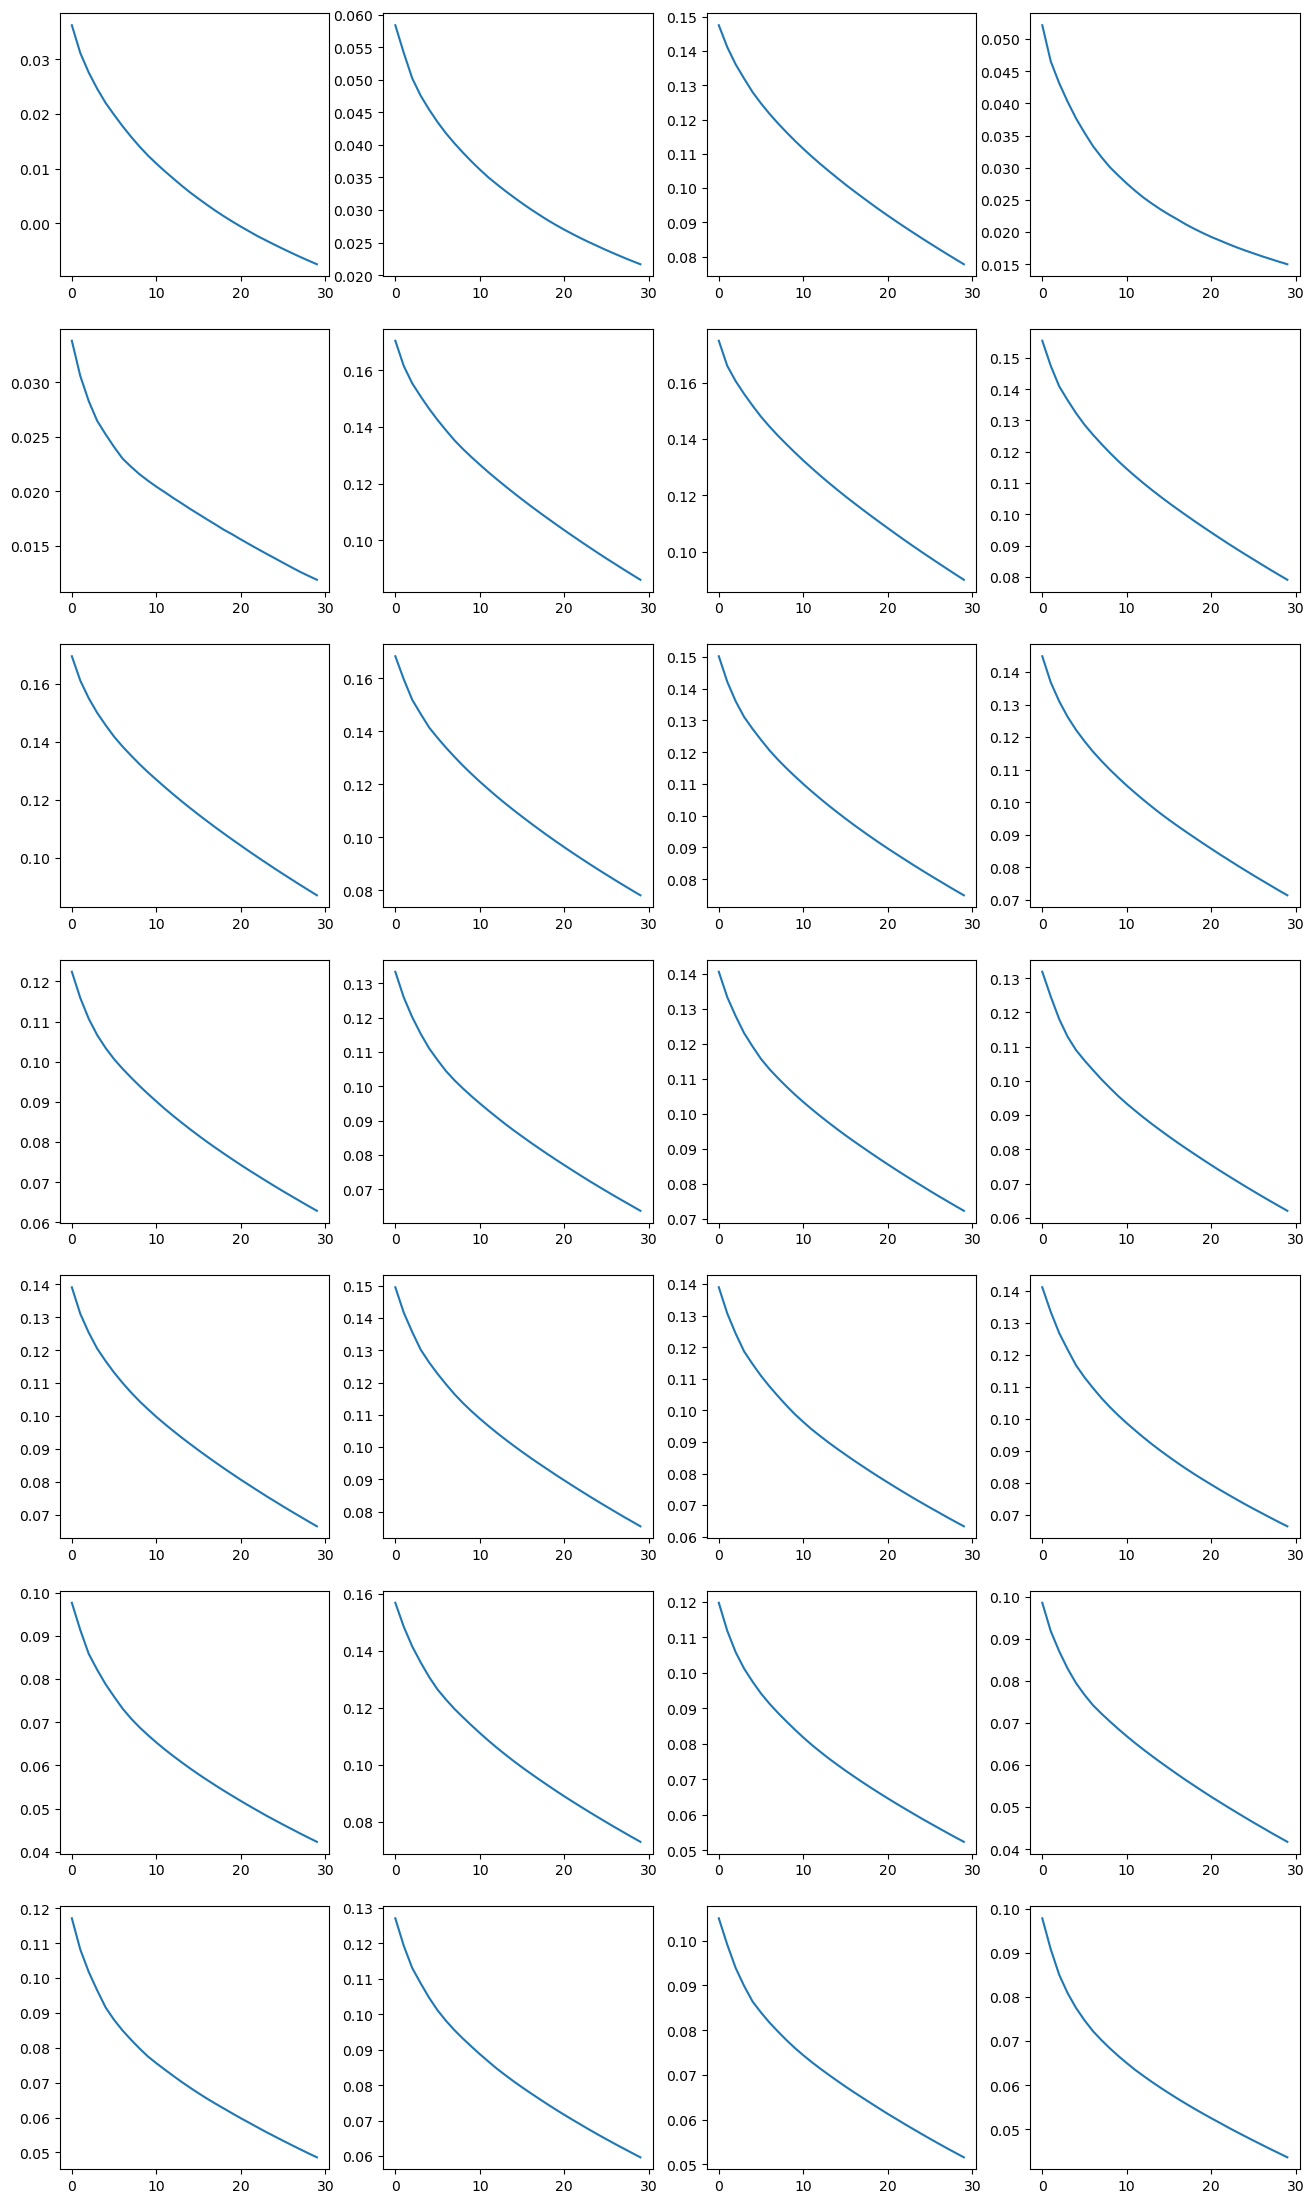

In [16]:
fig, ax = plt.subplots(7, 4, figsize=(16, 28))
for i in range(28):
    a = ax[np.unravel_index(i, (7, 4))]
    a.plot(np.divide(np.mean(scores_data[i, 1, ...], axis=0) - np.mean(lqg_loss[i]), np.mean(lqg_loss[i])))
    #a.plot(np.mean(scores[i, 1, ...], axis=0))

In [15]:
lqg_loss.shape

(28, 5)

In [23]:
scores_data.shape

(28, 2, 5, 30)

In [ ]:
# Plot instead the LQG spectrum
lqg_spec = []
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    # Calculate FCCA statistic in the ambient space
    cross_covs = torch.tensor(calc_cross_cov_mats_from_data(X[train_idxs], T=4))
    X = X @ np.linalg.inv(cross_covs[0])
    X = X[::-1, :]
    cross_covs_rev = torch.tensor(calc_cross_cov_mats_from_data(X, T=4))

    if readout_strategy == 'mixed':
        N = ccm_fwd.shape[1]
        Vlag = V_flat.reshape(N, d)
    else:
        N = ccm_fwd.shape[1]//lag
        V = V_flat.reshape(N, d)
        if readout_strategy == 'lagged':
            Vlag = torch.tile(V, (lag, 1))
        elif readout_strategy == 'sametime':
            Vlag = torch.vstack([V, torch.tile(torch.zeros(V.shape), (lag - 1, 1))])

    ortho_reg_val = ortho_reg_fn(ortho_lambda, Vlag)
    mmse_fwd = calc_mmse_from_cross_cov_mats(ccm_fwd, Vlag, project_mmse=project_mmse)    

    # Key change 06/28/22: In the reverse time direction, the readout is taken to be y = C Pi x_a = C x. 
    # This is implemented here by scaling Vlag by ccm_fwd[0]
    Vlag_rev = torch.matmul(ccm_fwd[0], Vlag)
    mmse_rev = calc_mmse_from_cross_cov_mats(ccm_rev, Vlag_rev, project_mmse=project_mmse)



Text(0, 0.5, 'Fraction of variance contained')

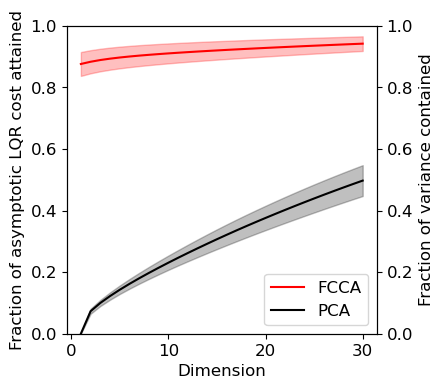

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x = np.array([1 - np.divide(np.mean(scores_data[i, 1, ...] - lqg_loss[i, :, np.newaxis], axis=0), np.mean(lqg_loss[i])) for i in range(28)])

y = np.array([np.mean(scores_data[i, 0, ...], axis=0) for i in range(28)])

ax.plot(np.arange(1, 31), np.mean(x, axis=0), 'r', label='FCCA')
ax.fill_between(np.arange(1, 31), np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), alpha=0.25, color='r')


ax2 = ax.twinx()
h2 = ax2.plot(np.arange(1, 31), np.mean(y, axis=0), 'k', label='PCA')
ax2.fill_between(np.arange(1, 31), np.mean(y, axis=0) - np.std(y, axis=0), np.mean(y, axis=0) + np.std(y, axis=0), alpha=0.25, color='k')

ax.set_ylim([0, 1])
ax2.set_ylim([0, 1])

fig.legend(loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=ax.transAxes, fontsize=12)
ax.set_xlabel('Dimension', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Fraction of asymptotic LQR cost attained', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('Fraction of variance contained', fontsize=12)
# fig.savefig('/home/akumar/nse/neural_control/figs/final/score_v_dim.pdf', bbox_inches='tight', pad_inches=0)
#ax.axhline(np.mean(lqg_loss), 1, 30)
# for i in range(28):
#     a = ax[np.unravel_index(i, (7, 4))]
#     a.plot(np.divide(np.mean(scores_data[i, 1, ...], axis=0) - np.mean(lqg_loss[i]), np.mean(lqg_loss[i])))
#     #a.plot(np.mean(scores[i, 1, ...], axis=0))

In [32]:
# Does this generically hold across simulated dynamical systems?

In [4]:
from neurosim.models.ssr import StateSpaceRealization as SSR, gen_random_model

In [5]:
A, B, C = gen_random_model(100)

In [6]:
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [17]:
reps = 20
dimvals = np.arange(1, 31)
scores = np.zeros((reps, dimvals.size))
ambient_scores = np.zeros(reps)

for i in tqdm(range(reps)):
    A, B, C = gen_random_model(180)
    ssr = SSR(A, B, C)
    ccm = ssr.autocorrelation(4)

    ambient_scores[i] = build_loss(torch.tensor(ccm), ccm.shape[1], ortho_lambda=0)(torch.tensor(np.ravel(np.eye(ccm.shape[1]))))

    for j, dim in enumerate(dimvals):
        lqgmodel = LQGCA(T=3, d=dim, n_init=5)
        lqgmodel.cross_covs = ccm
        lqgmodel.fit_projection()
        scores[i, j] = -1*np.max(lqgmodel.scores)

100%|██████████| 20/20 [09:35<00:00, 28.78s/it]


In [20]:
scores[0, :]

array([692.89204685, 662.44823802, 635.3850301 , 611.03523868,
       589.42425298, 570.02604125, 552.35935767, 536.15174981,
       521.98218157, 508.84204485, 496.44649538, 485.13625581,
       474.82010904, 465.07561094, 455.76694764, 446.89809179,
       438.69408029, 430.86388861, 423.38626517, 416.37902017,
       409.72097483, 403.40040278, 397.31412604, 391.50503164,
       385.96570563, 380.5980657 , 375.48238817, 370.59977265,
       365.8630214 , 361.34959296])

In [19]:
ambient_scores

array([201.59617386, 200.91016637, 201.21354899, 201.30186498,
       201.32212144, 200.74648559, 201.15204937, 201.66763426,
       202.05262043, 201.37099921, 201.08656285, 201.33602848,
       201.30153486, 201.22457339, 200.89682438, 200.49203024,
       201.21714131, 200.88178401, 201.08190321, 201.27570102])

In [21]:
(scores[i] - ambient_scores[i]

array([492.49305625, 462.1759992 , 436.05033912, 412.6636805 ,
       392.20830772, 373.6756278 , 356.51666755, 341.02383236,
       326.4734492 , 313.36614761, 300.97059623, 289.4414356 ,
       278.5560972 , 268.35188418, 258.68909789, 249.49142055,
       240.75886151, 232.34763427, 224.6289043 , 217.24590305,
       210.31535937, 203.75537699, 197.42623607, 191.57594619,
       185.94483842, 180.53280886, 175.35916739, 170.32672003,
       165.59559321, 161.05216493])

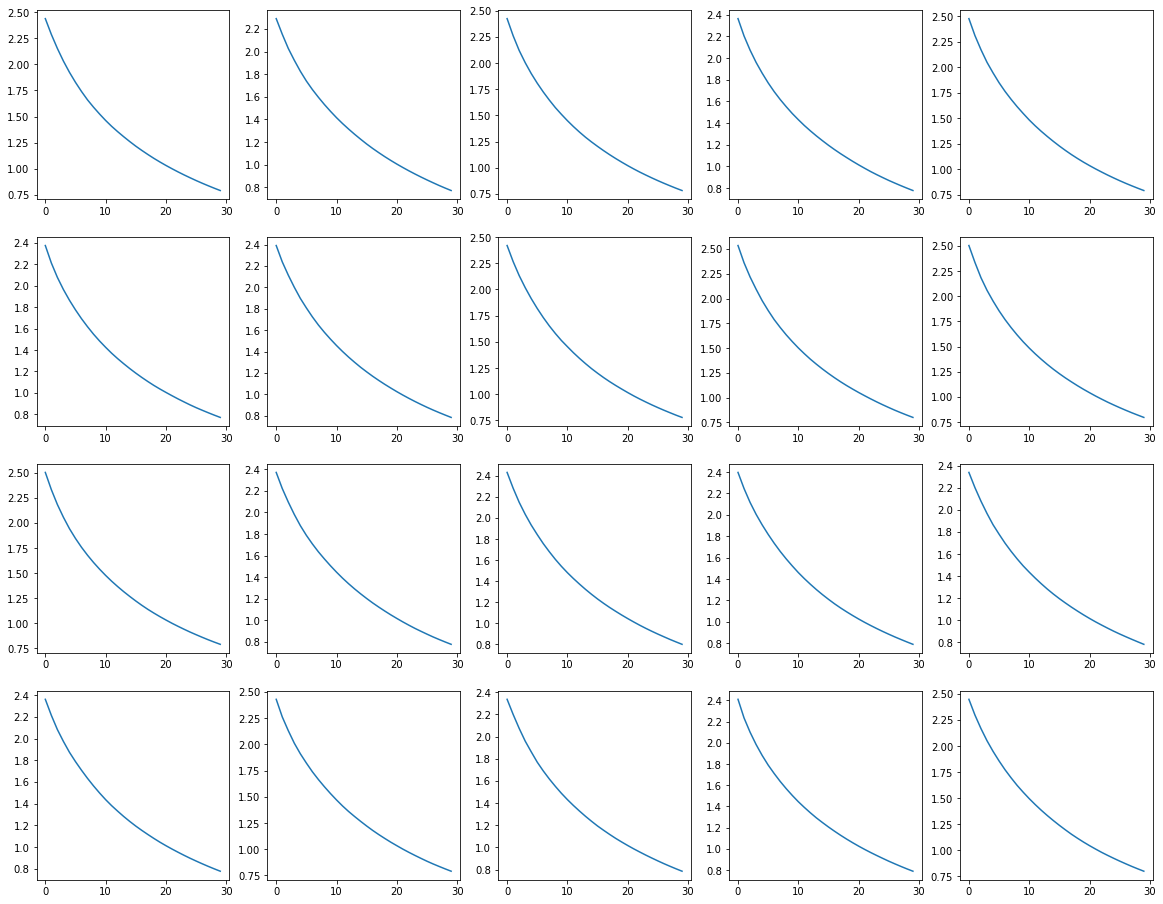

In [22]:
fig, ax = plt.subplots(4, 5, figsize=(20, 16))
for i in range(reps):
    a = ax[np.unravel_index(i, (4, 5))]
    a.plot(np.divide(scores[i] - ambient_scores[i], ambient_scores[i]))

### Peanut

In [32]:
with open('/home/akumar/nse/neural_control/data/peanut_decoding_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)

In [46]:
epochs

array([ 2,  4,  6,  8, 10, 12, 14, 16])

In [53]:
np.unique(peanut_df['dimreduc_method'].values)

array(['DCA', 'KCA', 'LQGCA', 'PCA'], dtype=object)

In [33]:
epochs = np.unique(peanut_df['epoch'].values)
folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}, {'T':3, 'causal_weights':(1, 1), 'n_init':5}]
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}, {'T':3, 'loss_type':'logdet', 'n_init':5},
                       {'T':3, 'loss_type':'additive', 'n_init':5}]

dimvals = np.unique(peanut_df['dim'].values)

# Pick one
decoder_arg = peanut_df.iloc[0]['decoder_args']
df = apply_df_filters(peanut_df, decoder_args=decoder_arg)

scores_peanut = np.zeros((epochs.size, len(dimreduc_methods), folds.size, dimvals.size))

for i, epoch in enumerate(epochs):
    for j, dr_method in enumerate(dimreduc_methods):
        for f, fold in enumerate(folds):
            for d, dimval in enumerate(dimvals):            
                if 'KCA' in dr_method:
                    df_ = apply_df_filters(df, epoch=epoch, dimreduc_method='KCA', fold_idx=fold, dim=dimval)
                    # Further filter by dimreduc_args
                    if dr_method == 'KCAfwd':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[0])
                    elif dr_method == 'KCArev':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[1])
                    elif dr_method == 'KCAeven':
                        df_ = apply_df_filters(df_, dimreduc_args=KCA_dimreduc_args[2])
                elif 'LQGCA' in dr_method:
                    df_ = apply_df_filters(df, epoch=epoch, dimreduc_method='LQGCA', fold_idx=fold, dim=dimval)
                    # Further filter by dimreduc_args
                    if dr_method == 'LQGCAtrace':
                        df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[0])
                    elif dr_method == 'LQGCAfro':
                        df_ = apply_df_filters(df_, dimreduc_args=LQGCA_dimreduc_args[1])
                else:
                    df_ = apply_df_filters(df, epoch=epoch, dimreduc_method=dr_method, fold_idx=fold, dim=dimval)

                try:
                    if dr_method == 'PCA':
                        scores_peanut[i, j, f, d] = np.sum(df_.iloc[0]['score'][0:d])/np.sum(df_.iloc[0]['score'])
                    else:
                        scores_peanut[i, j, f, d] = df_.iloc[0]['score'].numpy()
                except:
                    pdb.set_trace()

In [34]:
from loaders import load_peanut

In [35]:
lqg_loss_peanut = np.zeros((len(epochs), 5))
for i, epoch in enumerate(epochs):
    #dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    dat = load_peanut('/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj', epoch=epoch, spike_threshold=200)
    X = np.squeeze(dat['spike_rates'])

    for j, (train_idxs, test_idxs) in enumerate(KFold(n_splits=5, shuffle=False).split(X)):
        # Calculate FCCA statistic in the ambient space
        ccm = torch.tensor(calc_cross_cov_mats_from_data(X[train_idxs], T=4))
        lqg_loss_peanut[i, j] = build_loss(ccm, ccm.shape[1], ortho_lambda=0)(torch.tensor(np.ravel(np.eye(ccm.shape[1]))))

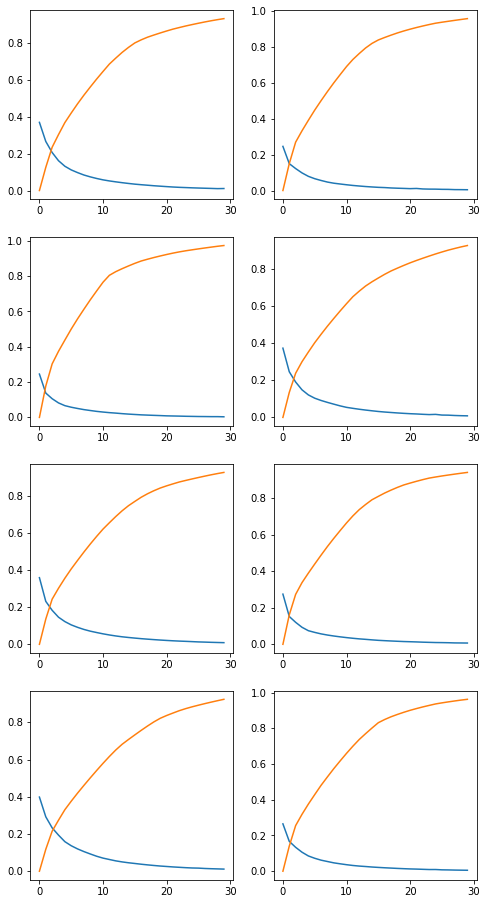

In [36]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))
for i in range(8):
    a = ax[np.unravel_index(i, (4, 2))]
    a.plot(np.divide(np.mean(scores_peanut[i, 1, ...] - lqg_loss_peanut[i, :, np.newaxis], axis=0), np.mean(lqg_loss_peanut[i])))
    a.plot(np.mean(scores_peanut[i, 0, ...], axis=0))

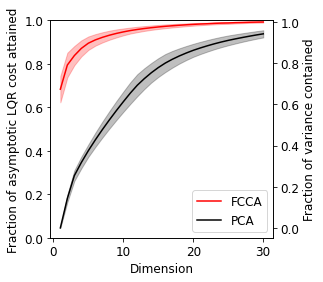

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x = np.array([1 - np.divide(np.mean(scores_peanut[i, 1, ...] - lqg_loss_peanut[i, :, np.newaxis], axis=0), np.mean(lqg_loss_peanut[i])) for i in range(8)])
y = np.array([np.mean(scores_peanut[i, 0, ...], axis=0) for i in range(8)])

ax.plot(np.arange(1, 31), np.mean(x, axis=0), 'r', label='FCCA')
ax.fill_between(np.arange(1, 31), np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), alpha=0.25, color='r')

ax2 = ax.twinx()
h2 = ax2.plot(np.arange(1, 31), np.mean(y, axis=0), 'k', label='PCA')
ax2.fill_between(np.arange(1, 31), np.mean(y, axis=0) - np.std(y, axis=0), np.mean(y, axis=0) + np.std(y, axis=0), alpha=0.25, color='k')

fig.legend(loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=ax.transAxes, fontsize=12)
ax.set_xlabel('Dimension', fontsize=12)
ax.set_ylim([0, 1])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Fraction of asymptotic LQR cost attained', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('Fraction of variance contained', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/final/score_v_dim_peanut.pdf', bbox_inches='tight', pad_inches=0)
#ax.axhline(np.mean(lqg_loss), 1, 30)
# for i in range(28):
#     a = ax[np.unravel_index(i, (7, 4))]
#     a.plot(np.divide(np.mean(scores_data[i, 1, ...], axis=0) - np.mean(lqg_loss[i]), np.mean(lqg_loss[i])))
#     #a.plot(np.mean(scores[i, 1, ...], axis=0))

### CV

In [5]:
with open('/home/akumar/nse/neural_control/data/cv_dimreduc_both.dat', 'rb') as f:
    cv_df = pickle.load(f)
cv_df = pd.DataFrame(cv_df)

In [6]:
np.unique(cv_df['dim'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [13]:
data_files = np.unique(cv_df['data_file'].values)
dimvals = np.unique(cv_df['dim'].values)
scores_cv = np.zeros((2, 2, 5, dimvals.size))

folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
LQGCA_dimreduc_args = [{'T':40, 'loss_type':'trace', 'n_init':5}]

for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):
        for d, dim_val in enumerate(dimvals):
            dfpca = apply_df_filters(cv_df, dimreduc_method='PCA', fold_idx=fold, data_file=data_file, dim=dim_val)
            dffcca = apply_df_filters(cv_df, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, data_file=data_file, dim=dim_val)
            assert(dfpca.shape[0] == 1)
            assert(dffcca.shape[0] == 1)

            scores_cv[i, 0, f, d] = np.sum(dfpca.iloc[0]['score'])
            scores_cv[i, 1, f, d] = dffcca.iloc[0]['score'].numpy()
        

In [15]:
from loaders import load_cv
from sklearn.decomposition import PCA

In [25]:
# get ambient scores
lqg_loss_cv = np.zeros((len(data_files), 5))
ambient_variance = np.zeros((len(data_files), 5))
for i, data_file in enumerate(data_files):
    dat = load_cv(data_file)
    X = np.squeeze(dat['spike_rates'])
    for j, (train_idxs, test_idxs) in tqdm(enumerate(KFold(n_splits=5, shuffle=False).split(X))):
        # Calculate FCCA statistic in the ambient space
        ccm = torch.tensor(calc_cross_cov_mats_from_data(X[train_idxs], T=40))
        lqg_loss_cv[i, j] = build_loss(ccm, ccm.shape[1], ortho_lambda=0)(torch.tensor(np.ravel(np.eye(ccm.shape[1]))))
        Xtrain = X[train_idxs]
        ambient_variance[i, j] = np.sum(PCA().fit(np.reshape(Xtrain, (-1, Xtrain.shape[-1]))).explained_variance_)

5it [06:53, 82.66s/it]
5it [03:29, 41.94s/it]


In [26]:
with open('cv_ambient.npz', 'wb') as f:
    np.save(f, lqg_loss_cv)
    np.save(f, ambient_variance)

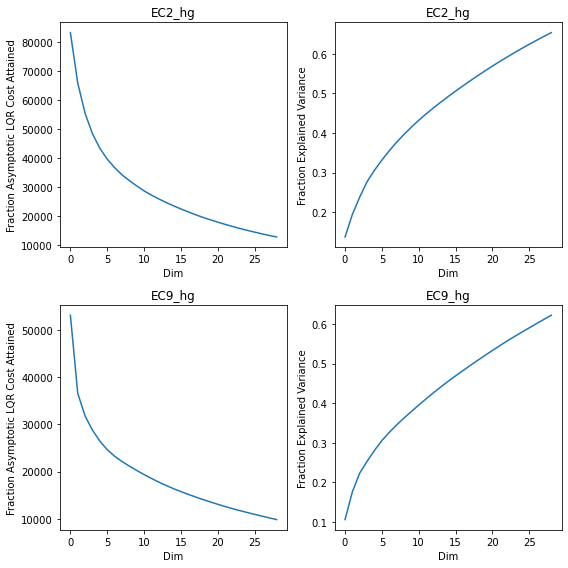

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[i, 0].plot(np.divide(np.mean(scores_cv[i, 1, ...] - lqg_loss_cv[i, :, np.newaxis], axis=0), np.mean(lqg_loss_cv[i])))
    ax[i, 1].plot(np.mean(np.divide(scores_cv[i, 0, ...], ambient_variance[i][:, np.newaxis]), axis=0))
    ax[i, 0].set_title(data_files[i].split('/')[-1].split('.h5')[0])
    ax[i, 1].set_title(data_files[i].split('/')[-1].split('.h5')[0])

    ax[i, 0].set_xlabel('Dim')
    ax[i, 1].set_xlabel('Dim')

    ax[i, 0].set_ylabel('Fraction Asymptotic LQR Cost Attained')
    ax[i, 1].set_ylabel('Fraction Explained Variance')
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/cv_scoresvdim.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x = np.array([1 - np.divide(np.mean(scores_peanut[i, 1, ...], axis=0) - np.mean(lqg_loss_peanut[i]), np.mean(lqg_loss_peanut[i])) for i in range(8)])
y = np.array([np.mean(scores_peanut[i, 0, ...], axis=0) for i in range(8)])

ax.plot(np.arange(1, 31), np.mean(x, axis=0), 'r', label='FCCA')
ax.fill_between(np.arange(1, 31), np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), alpha=0.25, color='r')

ax2 = ax.twinx()
h2 = ax2.plot(np.arange(1, 31), np.mean(y, axis=0), 'k', label='PCA')
ax2.fill_between(np.arange(1, 31), np.mean(y, axis=0) - np.std(y, axis=0), np.mean(y, axis=0) + np.std(y, axis=0), alpha=0.25, color='k')

fig.legend(loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=ax.transAxes, fontsize=12)
ax.set_xlabel('Dimension', fontsize=12)
ax.set_ylim([0, 1])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Fraction of asymptotic LQR cost attained', fontsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylabel('Fraction of variance contained', fontsize=12)
fig.savefig('/home/akumar/nse/neural_control/figs/final/score_v_dim_peanut.pdf', bbox_inches='tight', pad_inches=0)
#ax.axhline(np.mean(lqg_loss), 1, 30)
# for i in range(28):
#     a = ax[np.unravel_index(i, (7, 4))]
#     a.plot(np.divide(np.mean(scores_data[i, 1, ...], axis=0) - np.mean(lqg_loss[i]), np.mean(lqg_loss[i])))
#     #a.plot(np.mean(scores[i, 1, ...], axis=0))